# 25 ways to take a numerical derivative of noisy data without being a jerk

This notebook builds on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

Some notes on notation and syntax:
  * dt: (float) time step (note: we concentrated on differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the time series you want to differentiate
  * x_hat: (np.array like x) the smoothed estimate of x
  * x_truth: (np.array like x) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array like x) the estimate of the derivative of x
  * dxdt_truth: (np.array like x) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [69]:
# external imports
import numpy as np

# local imports
import pynumdiff
simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [75]:
# simulation parameters

# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.125]

# time step and time series length
dt = 0.01
timeseries_length = 4 # steps

In [76]:
# simulate data

x, x_truth, dxdt_truth, extras = simulate.pi_control(dt=dt,
                                                   timeseries_length=timeseries_length,
                                                   noise_type=noise_type, 
                                                   noise_parameters=noise_parameters)

In [77]:
# For our toy problems we can optimize the parameters in one of two options:
# 1. Use the known dxdt to find the best parameters 
# 2. Actual dxdt is unknown

# In the real world, option (1) is not possible. 

# This notebook allows you to run the optimization with either option:
# cheat=True selects option (1)
# cheat=False selects option (2)

cheat = False

if cheat:
    dxdt_truth_vals = dxdt_truth
else:
    dxdt_truth_vals = None

In [82]:
# For option (2), the optimization routine uses a hyperparameter, tvgamma, to determine how smooth
# dxdt_hat should be (larger value = more smoothness).

# The parameter tvgamma is the weighting factor for a total variation regularization 
# of the estimated derivative.

if cheat:
    tvgamma = 0 # since we are optimizing on the actual values, no need to regularize
else:
    tvgamma = 0.0005

# 1. Finite Difference

### 1.1 Finite Difference: First Order

RMS error in velocity:  7.087553691639919


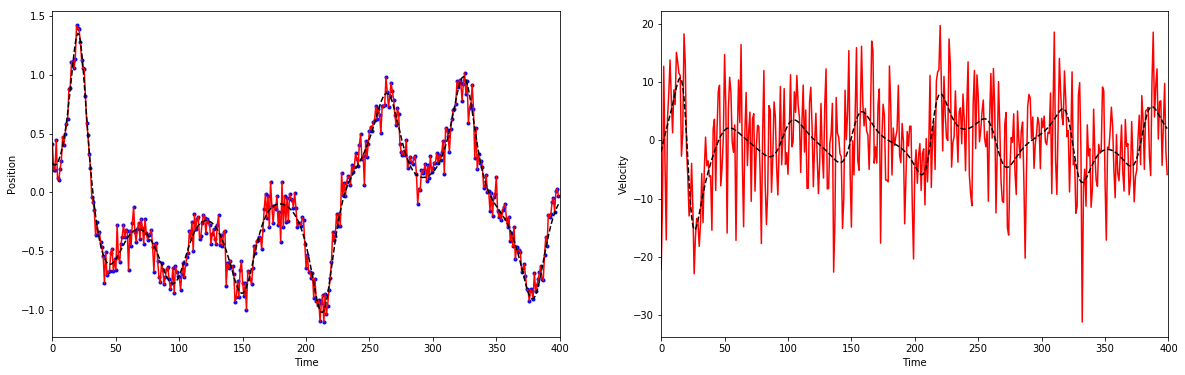

In [6]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.2 Finite Difference: Second Order

RMS error in velocity:  7.087553691639919


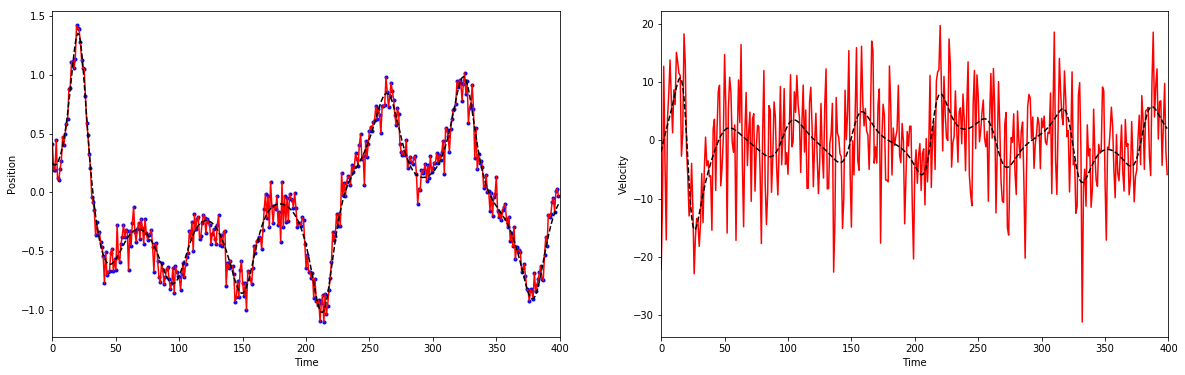

In [7]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 1.3 Finite Difference: Iterated First Order

Optimal parameters:  [40]
RMS error in velocity:  1.1383917665052243


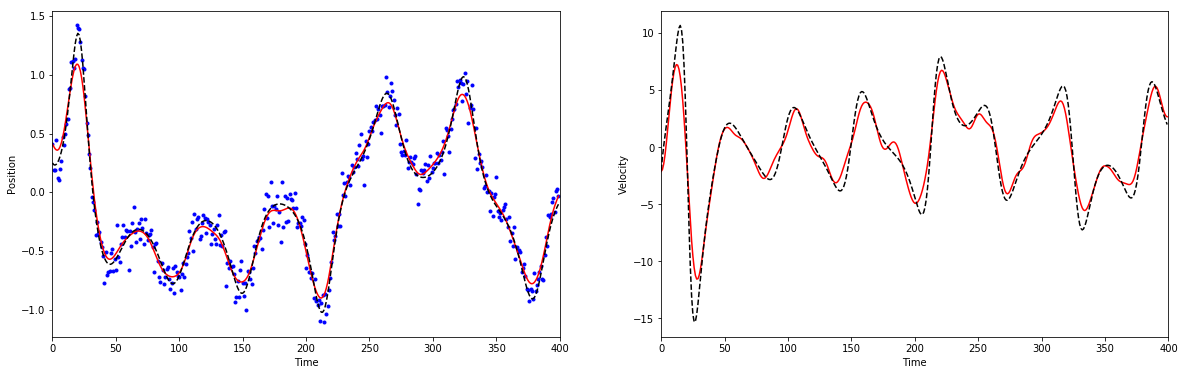

In [14]:
params, val = pynumdiff.optimize.finite_difference.first_order(x, dt, params=None, 
                                                               options={'iterate': True},
                                                               tvgamma=tvgamma,
                                                               dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

# 2. Smooth Finite Difference

### 2.1 Smooth Finite Difference: Median smoothing

Optimal parameters:  [10, 7]
RMS error in velocity:  2.3989183936316274


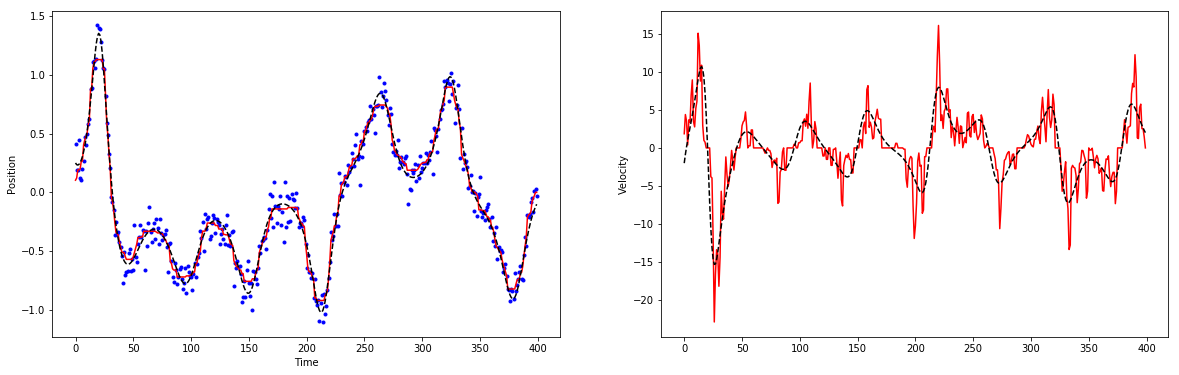

In [9]:
params, val = pynumdiff.optimize.smooth_finite_difference.mediandiff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.mediandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.2 Smooth Finite Difference: Mean smoothing

Optimal parameters:  [5, 5]
RMS error in velocity:  0.9520203361051249


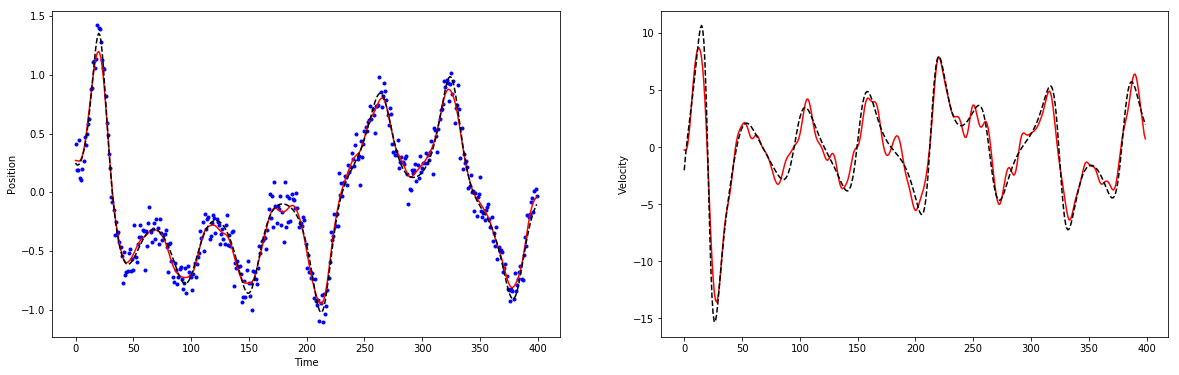

In [10]:
params, val = pynumdiff.optimize.smooth_finite_difference.meandiff(x, dt, params=None, 
                                                                   options={'iterate': True},
                                                                   tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.meandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.3 Smooth Finite Difference: Gaussian smoothing

Optimal parameters:  [19, 1]
RMS error in velocity:  0.9557994064583305


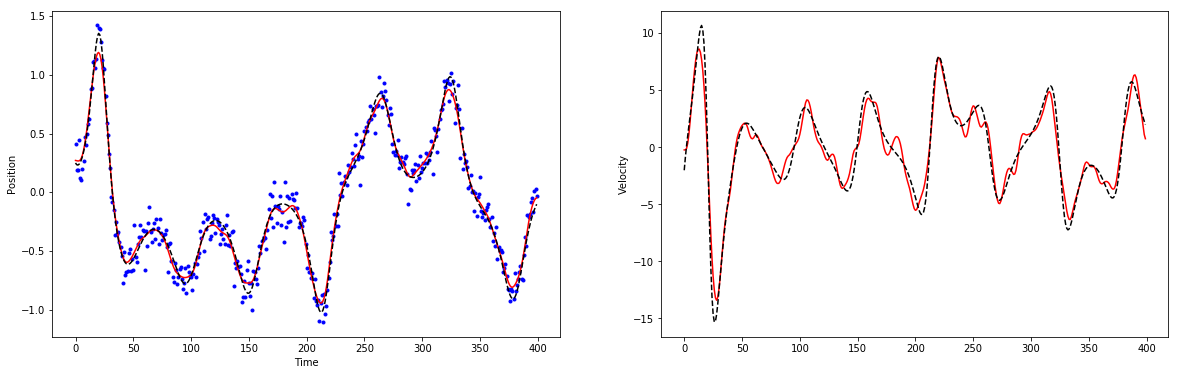

In [11]:
params, val = pynumdiff.optimize.smooth_finite_difference.gaussiandiff(x, dt, params=None, 
                                                                       options={'iterate': True},
                                                                       tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.gaussiandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.4 Smooth Finite Difference: Friedrichs smoothing

Optimal parameters:  [17, 1]
RMS error in velocity:  0.9534640094560757


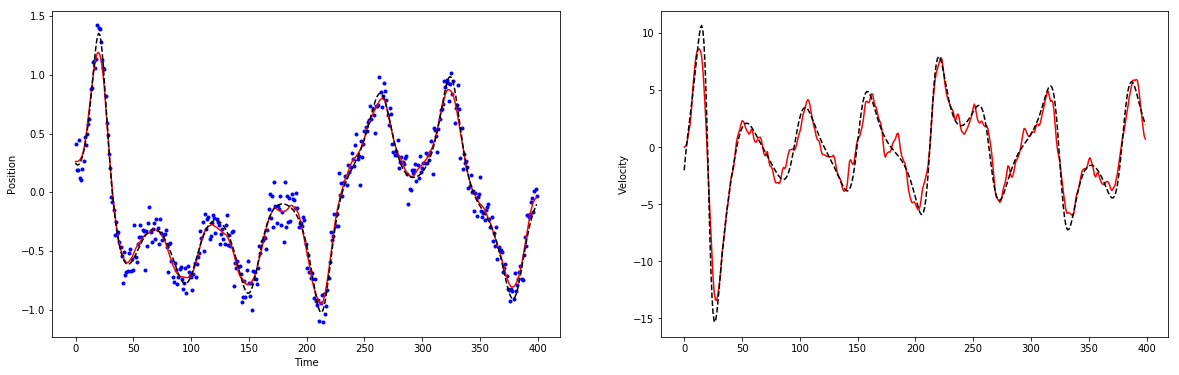

In [12]:
params, val = pynumdiff.optimize.smooth_finite_difference.friedrichsdiff(x, dt, params=None, 
                                                                         options={'iterate': True},
                                                                         tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.friedrichsdiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.5 Smooth Finite Difference: Butterworth smoothing

Optimal parameters:  [3, 0.03749074074074076, 1]
RMS error in velocity:  0.3483178116638233


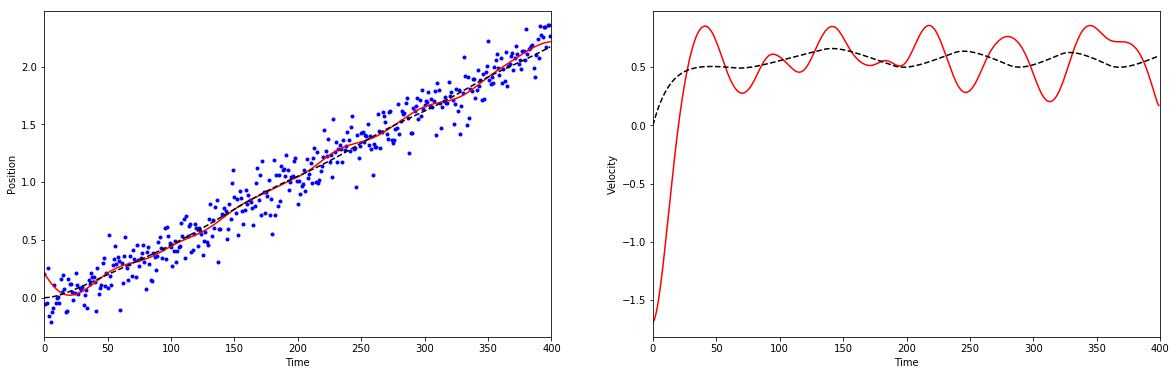

In [84]:
params, val = pynumdiff.optimize.smooth_finite_difference.butterdiff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.6 Smooth Finite Difference: Spline smoothing

Optimal parameters:  [3, 0.33765368592186146, 10]
RMS error in velocity:  1.5928311217661533


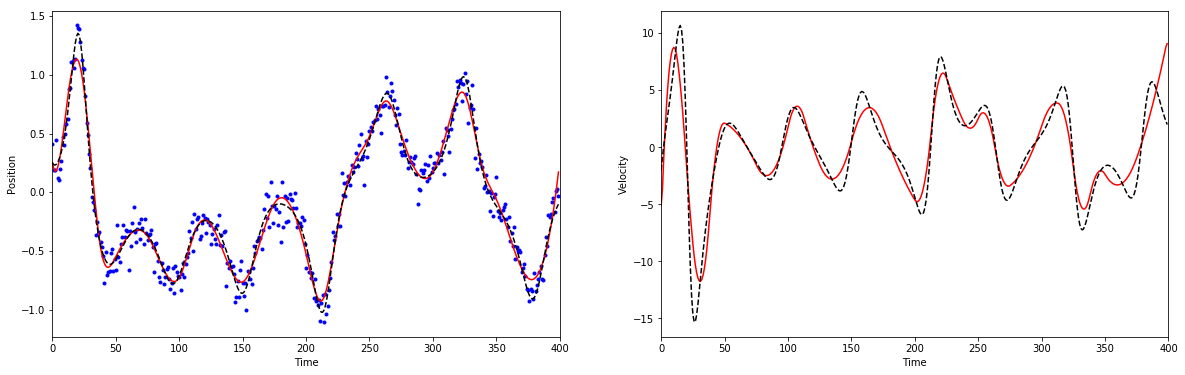

In [66]:
params, val = pynumdiff.optimize.smooth_finite_difference.splinediff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.splinediff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

# 3. Total Variation Regularization

### 3.1 Iterative Total Variation Regularization (regularized velocity)

Optimal parameters:  [1, 0.004492187499999984]
RMS error in velocity:  1.3138565199151546


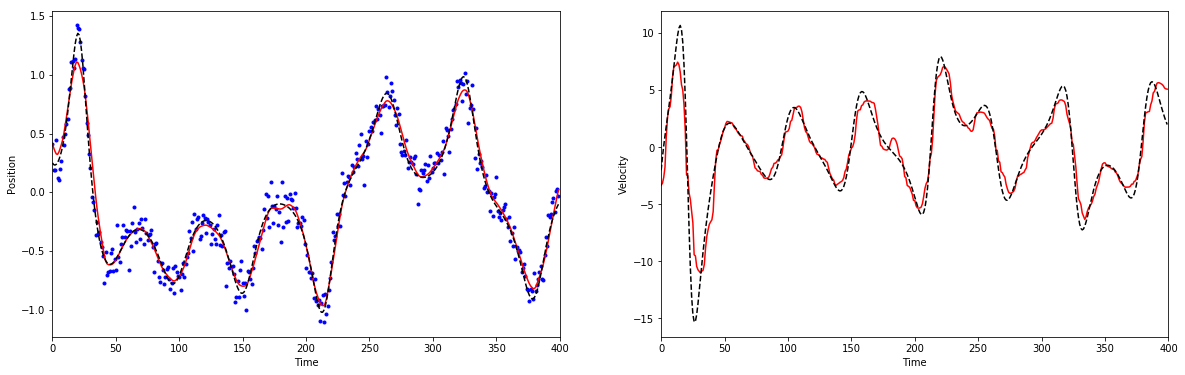

In [7]:
params, val = pynumdiff.optimize.total_variation_regularization.iterative_velocity(x, dt, params=None, 
                                                                                   tvgamma=tvgamma,
                                                                                   dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.iterative_velocity(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.2 Convex Total Variation Regularization: regularize velocity

Optimal parameters:  [2.173125000000008]
RMS error in velocity:  1.2574033373248554


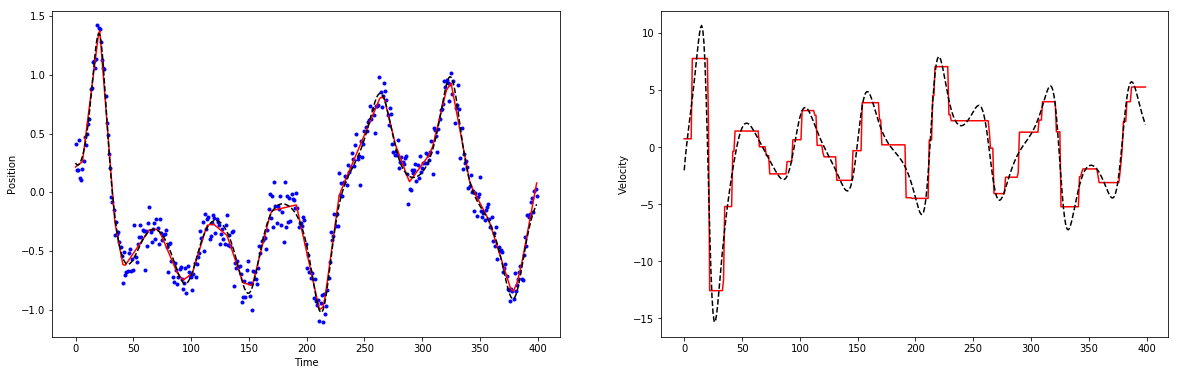

In [15]:
params, val = pynumdiff.optimize.total_variation_regularization.velocity(x, dt, params=None, 
                                                                         tvgamma=tvgamma,
                                                                         dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.velocity(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.3 Convex Total Variation Regularization: regularize acceleration

Optimal parameters:  [184.5703125]
RMS error in velocity:  0.1159329788891115


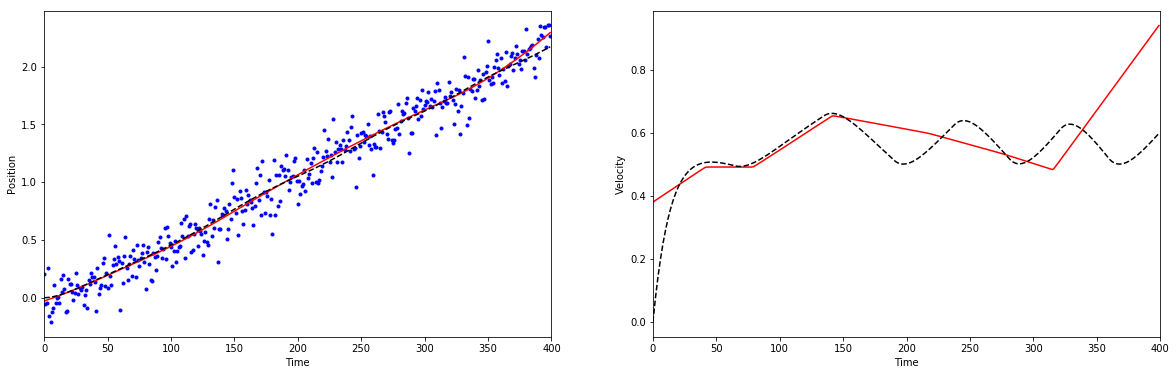

In [83]:
params, val = pynumdiff.optimize.total_variation_regularization.acceleration(x, dt, params=None, 
                                                                             tvgamma=tvgamma,
                                                                             dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.acceleration(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.4 Convex Total Variation Regularization: regularize jerk

Optimal parameters:  [9097.5]
RMS error in velocity:  0.12321982742861971


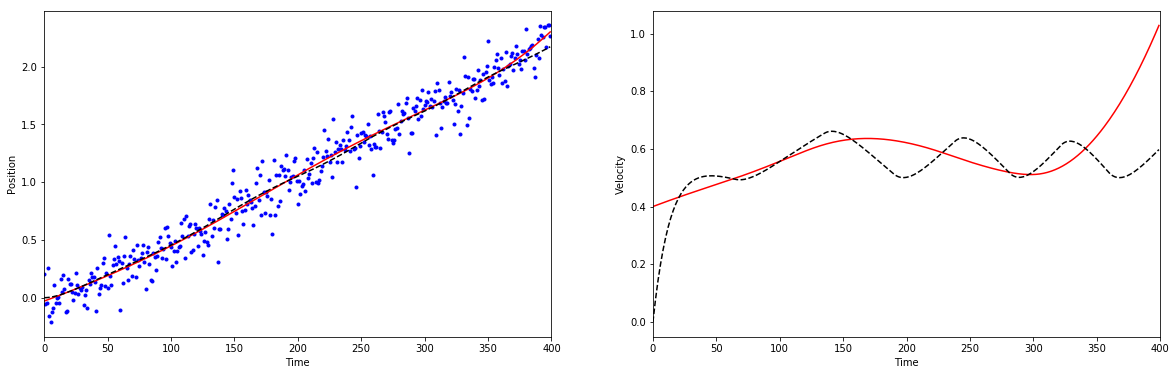

In [81]:
params, val = pynumdiff.optimize.total_variation_regularization.jerk(x, dt, params=None, 
                                                                     tvgamma=tvgamma,
                                                                    dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.jerk(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.5 Convex Total Variation Regularization: regularize acceleration with gaussian smoothing

Optimal parameters:  [4, 1]
RMS error in velocity:  0.8482141437574252


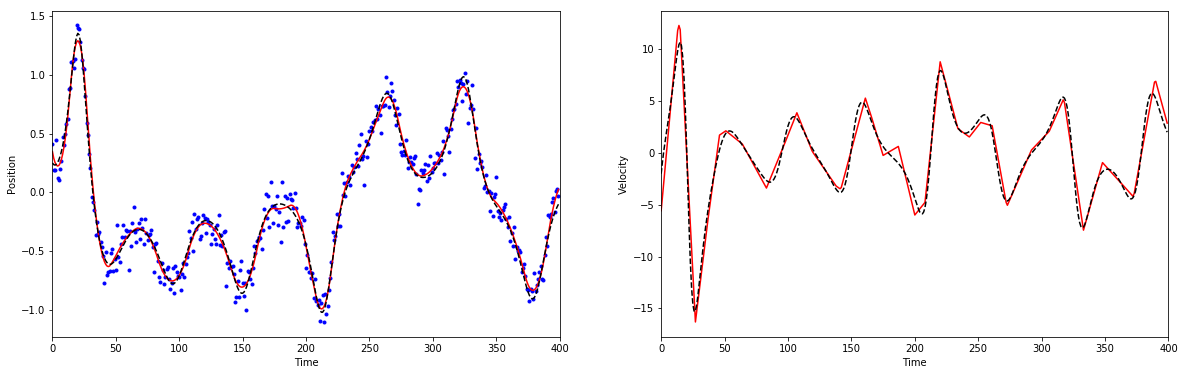

In [8]:
params, val = pynumdiff.optimize.total_variation_regularization.smooth_acceleration(x, dt, params=None, 
                                                                             tvgamma=tvgamma,
                                                                             dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.total_variation_regularization.smooth_acceleration(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

# 4. Linear Models

### 4.1 Linear Models: Spectral derivative

Optimal parameters:  [0.04875000000000001]
RMS error in velocity:  0.8884618670129099


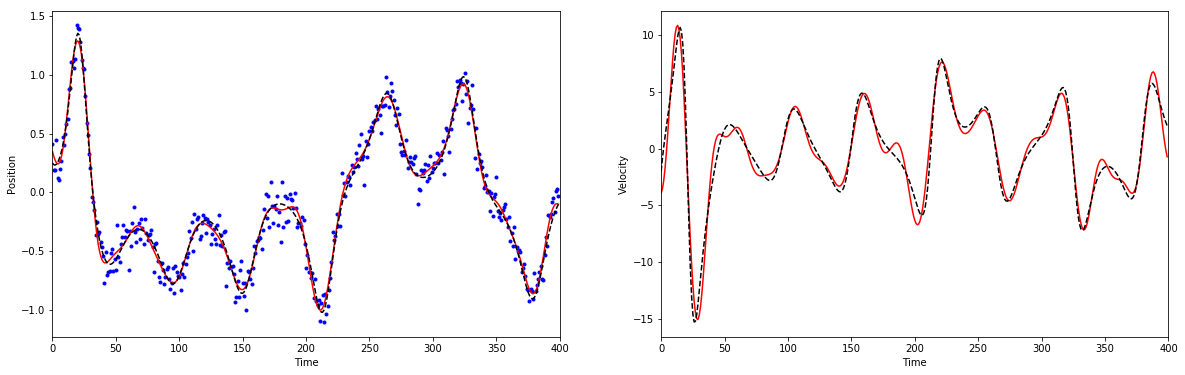

In [68]:
params, val = pynumdiff.optimize.linear_model.spectraldiff(x, dt, params=None, 
                                                           tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.spectraldiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.2 Linear Models: Sliding polynomial fit

Optimal parameters:  [8, 84]
RMS error in velocity:  0.953475464226681


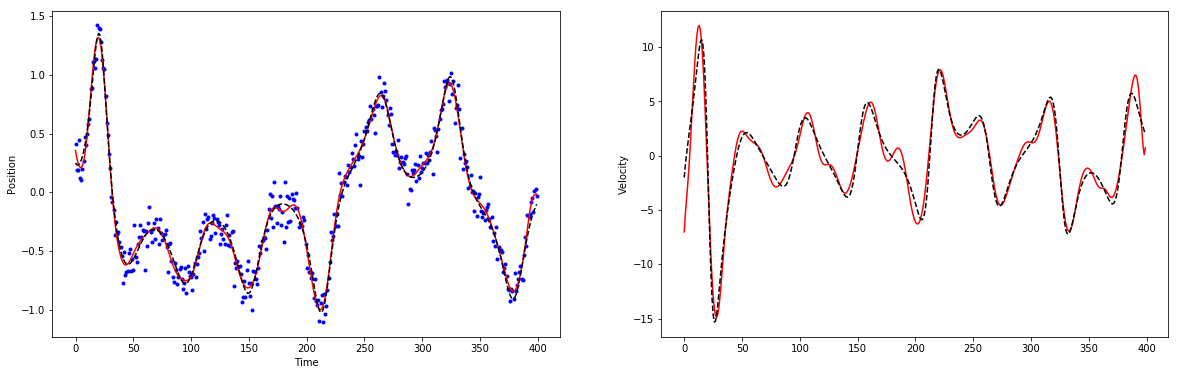

In [19]:
params, val = pynumdiff.optimize.linear_model.polydiff(x, dt, params=None, 
                                                       tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.polydiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.3 Linear Models: Savitzky-Golay filter

Optimal parameters:  [3, 15]
RMS error in velocity:  1.0454365543840127


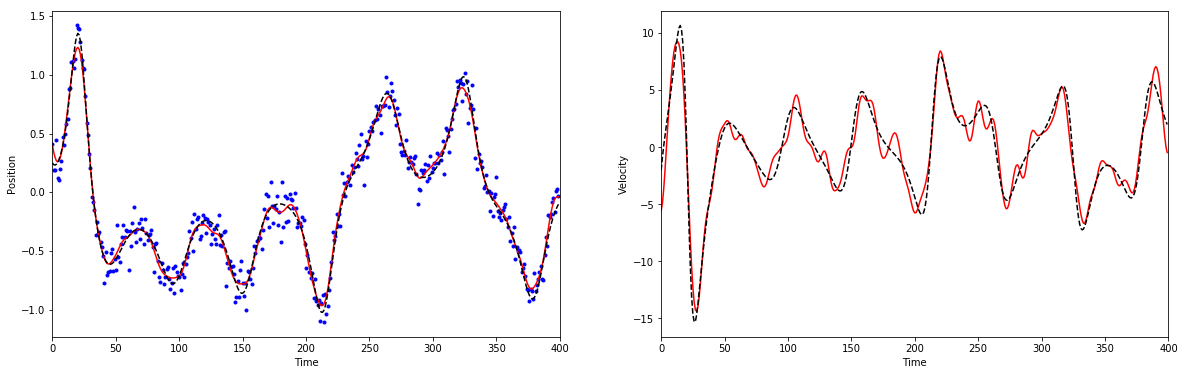

In [9]:
params, val = pynumdiff.optimize.linear_model.savgoldiff(x, dt, params=None, 
                                                         tvgamma=tvgamma,
                                                         dxdt_truth=dxdt_truth_vals,
                                                         options={'smooth': True})
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.savgoldiff(x, dt, params, options={'smooth': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.4 Linear Models: Sliding chebychev polynomial fit

Optimal parameters:  [3, 32]
RMS error in velocity:  0.9160539506107773


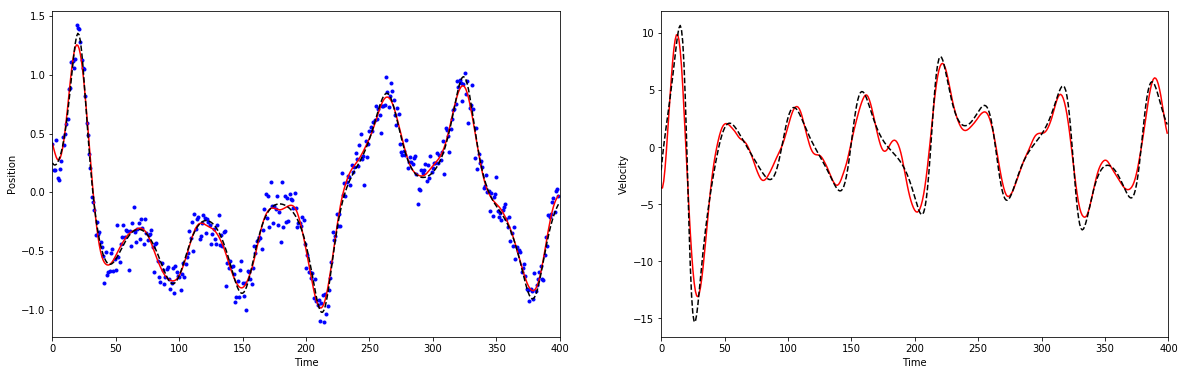

In [10]:
params, val = pynumdiff.optimize.linear_model.chebydiff(x, dt, params=None, 
                                                        tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.chebydiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.5 Linear Models: Sliding dynamic mode decomposition fit

/home/caveman/BMD2/lib/python3.5/site-packages/pynumdiff-0.1.dev0-py3.5.egg/pynumdiff/linear_model/__linear_model__.py:415: RuntimeWarning: invalid value encountered in true_divide


Optimal parameters:  [190, 10, 93]
RMS error in velocity:  0.7943779796122743


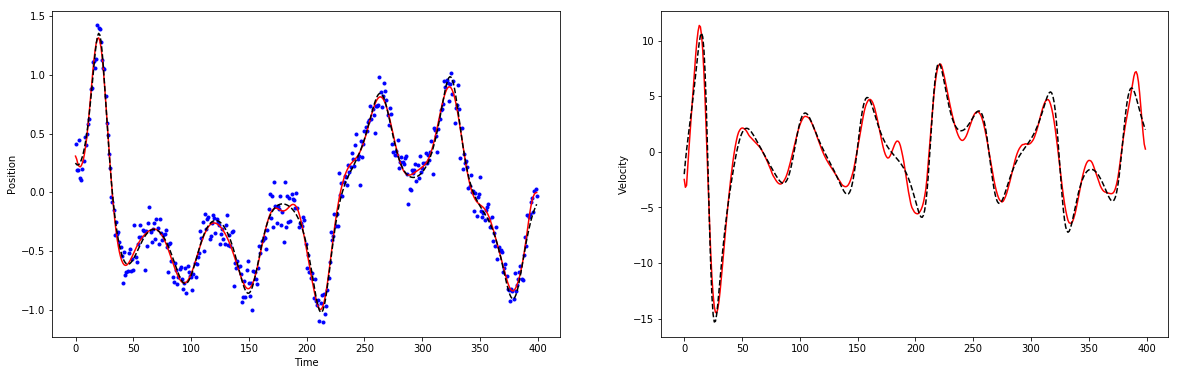

In [21]:
params, val = pynumdiff.optimize.linear_model.dmddiff(x, dt, params=None, 
                                                       tvgamma=tvgamma,
                                                      dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.dmddiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.6 Linear Models: Sliding linear time invariant system fit

/home/caveman/BMD2/lib/python3.5/site-packages/pynumdiff-0.1.dev0-py3.5.egg/pynumdiff/linear_model/__linear_model__.py:111: RuntimeWarning: invalid value encountered in true_divide
/home/caveman/BMD2/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


Optimal parameters:  [3, 0.04117283950617284, 45]
RMS error in velocity:  0.9285973601222147


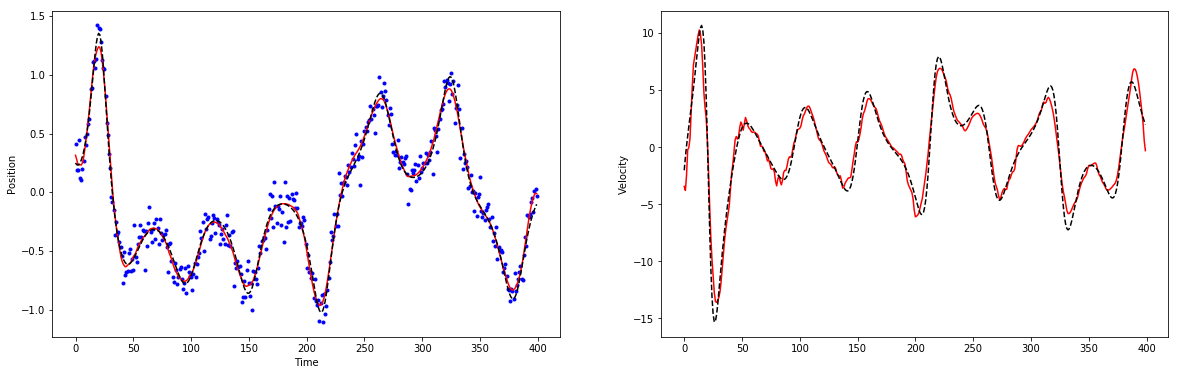

In [22]:
params, val = pynumdiff.optimize.linear_model.lineardiff(x, dt, params=None, 
                                                         tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.linear_model.lineardiff(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

# Kalman smoothing

### 5.1 Kalman smoothing: constant velocity (forward-backward)

Optimal parameters:  [0.009842140558831303, 0.041250000000000064]
RMS error in velocity:  1.3495614492367056


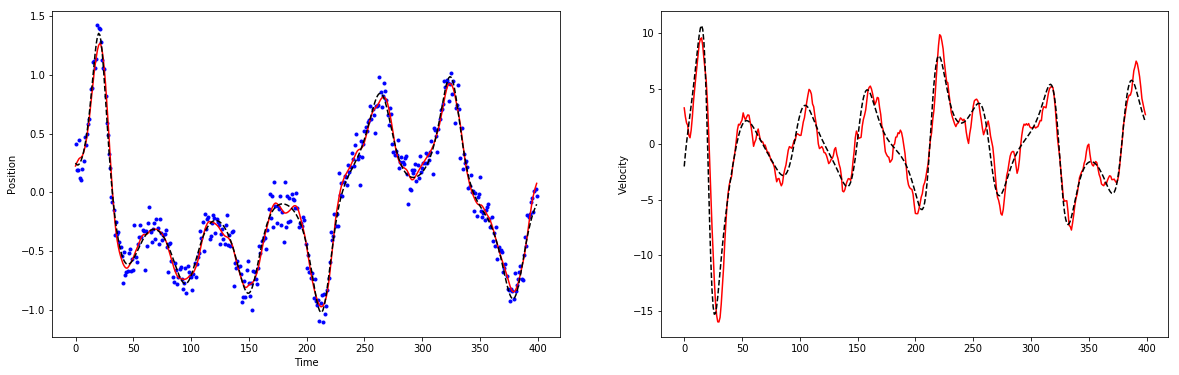

In [23]:
params, val = pynumdiff.optimize.kalman_smooth.constant_velocity(x, dt, params=None, 
                                                                 tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_velocity(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.2 Kalman smoothing: constant acceleration (forward-backward)

Optimal parameters:  [0.01320619383481494, 0.110625]
RMS error in velocity:  0.1170669991772945


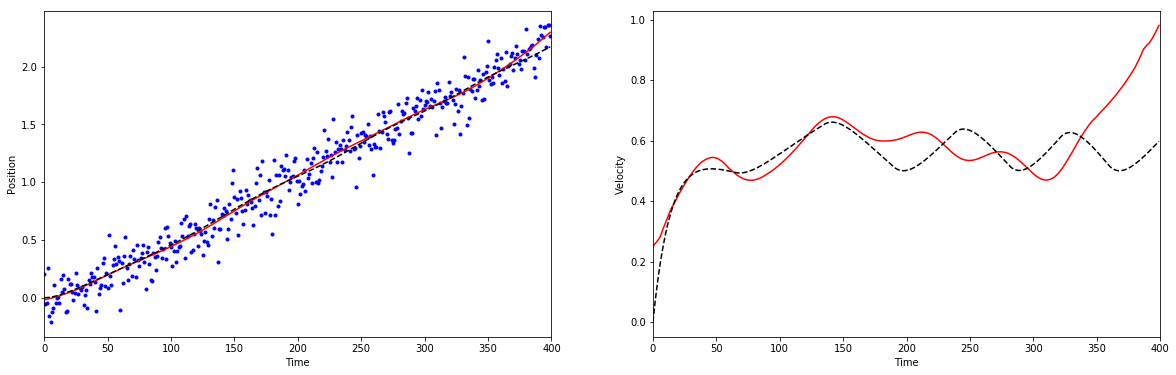

In [85]:
params, val = pynumdiff.optimize.kalman_smooth.constant_acceleration(x, dt, params=None, 
                                                                 tvgamma=tvgamma,
                                                                    dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_acceleration(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.3 Kalman smoothing: constant jerk (forward-backward)

Optimal parameters:  [0.007842140558831305, 8860.83984375]
RMS error in velocity:  1.8570879996423164


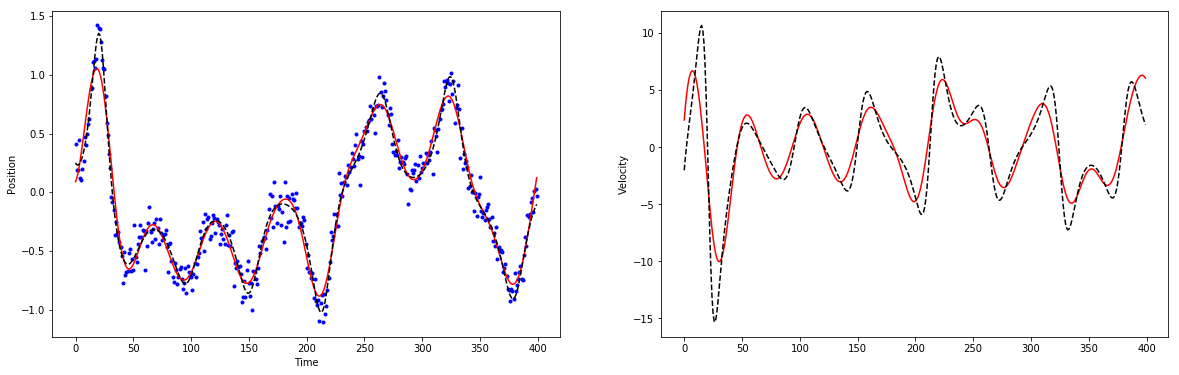

In [25]:
params, val = pynumdiff.optimize.kalman_smooth.constant_jerk(x, dt, params=None, 
                                                                 tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_jerk(x, dt, params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

# Neural networks

Neural net parameter and option optimization is not implemented. This is too complex a problem to easily optimize.